In [1]:
import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea.btag_tools import BTagScaleFactor
from coffea import hist
import pandas as pd
import uproot_methods
import uproot
import awkward
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.config_helpers import *
from Tools.helpers import mergeArray, mt

from Tools.objects import Collections
from Tools.cutflow import Cutflow

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

In [2]:
def pad_and_flatten(val): 
    try:
        return val.pad(1, clip=True).fillna(0.).flatten()
    except AttributeError:
        return val.flatten()

In [3]:
# Imports and defintions for the actual analysis to run

from Tools.WH_objects       import *
from Tools.WH_scalefactors  import LeptonSF
from Tools.WH_deepAK8       import getWTagSF
from Tools.WH_signalWeights import getSignalWeight
from Tools.WH_samples       import * 

year = 2016
signalPoint = 'TChiWH_800_1'

In [17]:
processesList = ['mC750_l1', 'WJets', 'TTJets', 'ST', 'ttW', 'WW', 'ZNuNu', 'QCD', 'Data']
lumis       = {2016: 36., 2017: 41.5, 2018: 60.}

In [15]:
class analysisProcessor(processor.ProcessorABC):
    """Processor used for running the analysis"""
    def __init__(self):
        
        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 2500)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        delta_axis          = hist.Bin("delta",     r"$\delta$", 100,0,10 )
        score_axis          = hist.Bin("score",     r"$score$", 100,0,1 )
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis           = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            
            "lead_AK8_msoftdrop":  hist.Hist("Counts", dataset_axis, mass_axis),
            "sublead_AK8_msoftdrop":  hist.Hist("Counts", dataset_axis, mass_axis),
             
            'mC750_l1':         processor.defaultdict_accumulator(int),
            'WJets':            processor.defaultdict_accumulator(int),
            'QCD':              processor.defaultdict_accumulator(int),
            'TTJets':           processor.defaultdict_accumulator(int),
            'ZNuNu':            processor.defaultdict_accumulator(int),
            'ST':               processor.defaultdict_accumulator(int),
            'ST_tW':            processor.defaultdict_accumulator(int),
            'ST_tChannel':      processor.defaultdict_accumulator(int),
            'ST_sChannel':      processor.defaultdict_accumulator(int),
            'ttW':              processor.defaultdict_accumulator(int),
            'ttZ':              processor.defaultdict_accumulator(int),
            'WW':               processor.defaultdict_accumulator(int),
            'WZ/ZZ':            processor.defaultdict_accumulator(int),
            'LL':               processor.defaultdict_accumulator(int),
            'Data':             processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
            'test1':            processor.defaultdict_accumulator(float),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        ## MET -> can switch to puppi MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"] 
        
        filters  = getFilters(df, year=year, dataset=dataset)
        triggers = getTriggers(df, year=year, dataset=dataset)
        
        muon_veto     = getMuons(df, WP='veto')
        electron_veto = getElectrons(df, WP='veto')
        #muon_med      = getMuons(df, WP='medium')
        #electron_med  = getElectrons(df, WP='medium')
        fatjet        = getFatJets(df)
        jet           = getJets(df)

        sf = LeptonSF(year=year)
        leptonSF = sf.get(electron_veto, muon_veto)
        
        # clean AK4 jets
        skimjet   = jet[(jet.pt>30) & (jet.jetId>1) & (abs(jet.eta)<2.4)]
        jet       = jet[~jet.match(muon_veto, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~jet.match(electron_veto, deltaRCut=0.4)] # remove jets that overlap with electrons
        jet       = jet[jet.pt.argsort(ascending=False)] # sort the jets
        extrajet  = jet[~jet.match(fatjet, deltaRCut=0.8)] # remove AK4 jets that overlap with AK8 jets
        btag      = getBTags(jet, year=year)
        
        # some gymnastics with AK8 jets
        leadingFatJets = fatjet[:,:2]
        leadingFatJet = fatjet[:,:1]
        subleadingFatJet = fatjet[:,1:2]
        
        difatjet = leadingFatJets.choose(2)
        dphiDiFatJet = np.arccos(np.cos(difatjet.i0.phi-difatjet.i1.phi))
        min_dphiFatJetMet4 = np.arccos(np.cos(fatjet[:,:4].phi-met_phi)).min()
        
        htag = getHTags(fatjet, year=year)        
        lead_htag = htag[htag.pt.argmax()]
        
        wtag = getWTags(fatjet, year=year)
        wtag = wtag[~wtag.match(htag, deltaRCut=0.8)]
        lead_wtag = wtag[wtag.pt.argmax()]
        
        if dataset.lower().count('data')==0:
            GenW = getGenW(df)
            wtag_SF = getWTagSF(wtag, GenW, year=year)
        
        wh = lead_htag.cross(lead_wtag)
        wh_deltaPhi = np.arccos(wh.i0.phi - wh.i1.phi)
        wh_deltaR = wh.i0.p4.delta_r(wh.i1.p4)
                
        mth = mt(htag.pt, htag.phi, met_pt, met_phi)

        ht = jet.pt.sum()

        wtag_sel = ( wtag.counts>0 & (abs(wtag.msoftdrop-80)<30).any())
        htag_sel = ( htag.counts>0 & (abs(htag.msoftdrop-125)<25).any())
        #stitchVar = 1 if dataset=='Data' else df["stitch"]
        
        ## define selections (maybe move to a different file at some point)
        
        output['totalEvents']['all'] += len(df['weight'])
        
        # Cutflow
        processes   = processesList
        weight      = np.ones(len(df['weight'])) if dataset=='Data' else df['weight']*df['puWeight']*leptonSF*wtag_SF
        lumis       = {2016: 36., 2017: 41.5, 2018: 60.}
        cfg['lumi'] = 1 if dataset=='Data' else lumis[year]
        fullweight  = weight*cfg['lumi']
        
        cutflow = Cutflow(output, df, cfg, processes, weight=weight)
        
        cutflow.addRow( 'filters',    filters )
        cutflow.addRow( 'triggers',   triggers )
        
        #cutflow.addRow( 'stitch',   (stitchVar ==1) )
        
        cutflow.addRow( 'skim',        ((met_pt>200) & (skimjet.counts>1)) )
        #cutflow.addRow( 'Exactly 1 e or mu',   ((electron_med.counts+muon_med.counts)==1) )
        cutflow.addRow( 'E/mu veto',   ((electron_veto.counts+muon_veto.counts)==1) )
        cutflow.addRow( 'MET>250',     (met_pt>250) )
        #cutflow.addRow( 'nJet>1',      (jet.counts>1) )
        #cutflow.addRow( 'nBTag>0',     (btag.counts>0) )
        
        baseline = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_fatjet>1',      (fatjet.counts>1) )
        cutflow.addRow( 'min_dphiFatJetMet4', (min_dphiFatJetMet4>0.5))
        cutflow.addRow( 'dphiDiFatJet', (dphiDiFatJet<2.5).all() ) # by using .all() I do not implicitely cut on the number of fat jets
        #cutflow.addRow( 'minmth>200',   (mth.min()>200) )
        

        vetoQCD = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_htag>0',     (htag_sel))
        cutflow.addRow( 'njet veto',     (extrajet.counts<2))
        cutflow.addRow( 'minmth>200',   (mth.min()>200) )

        htag_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_wtag>0',     (wtag_sel))
        
        wtag_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_htag>0, N_wtag>0',     (htag_sel & wtag_sel))

        signal_selection = cutflow.selection
        
        ### And fill the histograms
        output['lead_AK8_msoftdrop'].fill(dataset=dataset, mass=leadingFatJet[vetoQCD].msoftdrop.flatten(), weight=fullweight[vetoQCD])
        output['sublead_AK8_msoftdrop'].fill(dataset=dataset, mass=subleadingFatJet[vetoQCD].msoftdrop.flatten(), weight=fullweight[vetoQCD])        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [6]:
runLocal = True

#scheduler_address = get_scheduler_address()

if not runLocal:
    # Get the scheduler from the dask_cluster notebook
    from dask.distributed import Client, progress

    c = Client(scheduler_address)

    ## for dask
    exe_args = {
        'client': c,
        #'savemetrics': True,
    }
    exe = processor.dask_executor
    
else:
    ## for local
    exe_args = {
        'workers': 4,
        'function_args': {'flatten': False}
    }
    exe = processor.futures_executor

if not runLocal:
    print(c)

In [7]:
overwrite = False
small = True

from Tools.WH_samples import * #fileset_2016, fileset_2016_small

if year == 2016:
    fileset_year = fileset_2016
    fileset_year_small = fileset_2016_small
elif year == 2017:
    fileset_year = fileset_2017
    fileset_year_small = fileset_2017_small
elif year == 2018:
    fileset_year = fileset_2018
    fileset_year_small = fileset_2018_small


fileset   = {'WJets': fileset_year['WJets'],
                'TTJets': fileset_year['TTJets'],
                'ST': fileset_year['ST'],
                'WW': fileset_year['WW'],
                'ttW': fileset_year['TTW'],
                'QCD': fileset_year['QCD'],
                'ZNuNu': fileset_year['ZNuNu'] + fileset_year['TTZ'] + fileset_year['VV'],
                'Data': fileset_year['MET'],
                }

fileset_small   = {'WJets': fileset_year_small['WJets'],
                'TTJets': fileset_year_small['TTJets'],
                'ST': fileset_year_small['ST'],
                'WW': fileset_year_small['WW'],
                'ttW': fileset_year_small['TTW'],
                'QCD': fileset_year_small['QCD'],
                'ZNuNu': fileset_year_small['ZNuNu'] + fileset_year_small['TTZ'] + fileset_year_small['VV'],
                'Data': fileset_year_small['MET'],
                }



# load the config and the cache
cfg = loadConfig()

cacheName = 'WH_LL_%s_small'%year if small else 'WH_LL_%s'%year

## WH_LL cache contains the plots for "resolved" like CRs

# histograms
histograms = []
histograms += ['N_AK4']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        fileset = fileset_small
        exe_args['workers'] = 4
    else:
        fileset = fileset
        exe_args['workers'] = 16
    
        
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=analysisProcessor(),
                                      executor=exe,
                                      executor_args=exe_args,
                                      #chunksize=250000,
                                      chunksize=100000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

In [8]:
# Cutflow
from Tools.helpers import getCutFlowTable

linesList= ['filters', 'triggers', 'skim',  'E/mu veto', 'MET>250', 'N_fatjet>1', 'min_dphiFatJetMet4', 'dphiDiFatJet', 'N_htag>0', 'njet veto', 'minmth>200', 'N_wtag>0', 'N_htag>0, N_wtag>0']
#linesList= ['filters_VR', 'triggers_VR', 'E/mu veto_VR', 'MET>250_VR', 'N_fatjet>1_VR', 'min_dphiFatJetMet4_VR', 'dphiDiFatJet_VR', 'N_htag>0_VR', 'N_wtag>0_VR']


processes = processesList
lines     = ['entry']
lines    += linesList
df        = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='mC750_l1')
df

,mC750_l1,WJets,TTJets,ST,ttW,WW,ZNuNu,QCD,Data,S/B
entry,0.0 +/- 0.0,170800.0 +/- 1300.0,380800.0 +/- 200.0,5566.0 +/- 40.0,2303.0 +/- 5.0,124000.0 +/- 300.0,61990.0 +/- 160.0,142900.0 +/- 800.0,56070.0 +/- 240.0,0.0
filters,0.0 +/- 0.0,170500.0 +/- 1300.0,380300.0 +/- 200.0,5558.0 +/- 40.0,2297.0 +/- 5.0,123800.0 +/- 300.0,61890.0 +/- 160.0,105400.0 +/- 700.0,25290.0 +/- 160.0,0.0
triggers,0.0 +/- 0.0,170500.0 +/- 1300.0,380300.0 +/- 200.0,5558.0 +/- 40.0,2297.0 +/- 5.0,123800.0 +/- 300.0,61890.0 +/- 160.0,105400.0 +/- 700.0,19000.0 +/- 140.0,0.0
skim,0.0 +/- 0.0,5858.0 +/- 241.0,22400.0 +/- 50.0,1430.0 +/- 22.0,597.9 +/- 2.5,16480.0 +/- 100.0,12000.0 +/- 80.0,84110.0 +/- 610.0,11880.0 +/- 110.0,0.0
E/mu veto,0.0 +/- 0.0,3893.0 +/- 195.0,11230.0 +/- 40.0,684.3 +/- 15.1,280.6 +/- 1.7,8248.0 +/- 73.0,1741.0 +/- 21.0,1883.0 +/- 91.0,2998.0 +/- 55.0,0.0
MET>250,0.0 +/- 0.0,1159.0 +/- 106.0,3884.0 +/- 23.0,264.8 +/- 9.8,144.3 +/- 1.2,3884.0 +/- 50.0,853.8 +/- 14.3,898.8 +/- 63.3,1194.0 +/- 35.0,0.0
N_fatjet>1,0.0 +/- 0.0,88.82 +/- 29.73,1079.0 +/- 12.0,80.97 +/- 5.94,60.37 +/- 0.82,792.8 +/- 22.4,163.7 +/- 6.0,775.1 +/- 59.0,248.0 +/- 15.7,0.0
min_dphiFatJetMet4,0.0 +/- 0.0,0.0 +/- 0.0,518.9 +/- 8.4,27.34 +/- 2.76,32.82 +/- 0.59,362.8 +/- 15.3,81.56 +/- 3.96,44.19 +/- 14.09,105.0 +/- 10.2,0.0
dphiDiFatJet,0.0 +/- 0.0,0.0 +/- 0.0,341.8 +/- 6.8,19.76 +/- 2.34,21.82 +/- 0.48,311.7 +/- 14.2,63.0 +/- 3.56,34.95 +/- 12.47,80.0 +/- 8.94,0.0
N_htag>0,0.0 +/- 0.0,0.0 +/- 0.0,32.01 +/- 2.07,1.084 +/- 0.477,2.853 +/- 0.168,5.321 +/- 1.882,5.636 +/- 1.018,0.0 +/- 0.0,4.0 +/- 2.0,0.0


In [44]:
from plots.helpers import *

useData         = True
normalize       = True


bins = {\
    'lead_AK8_msoftdrop':  {'axis': 'mass',    'overflow':'over',  'bins': hist.Bin('mass', r'$sd mass (lead. AK8) \ (GeV)$', 25, 0, 250)},
    'sublead_AK8_msoftdrop':  {'axis': 'mass',    'overflow':'over',  'bins': hist.Bin('mass', r'$sd mass (sublead. AK8) \ (GeV)$', 125, 0, 250)},
    }

Plots will appear here: /home/users/ewallace/public_html/sdplots/
lead_AK8_msoftdrop
lead_AK8_msoftdrop mass


/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


TypeError: saveFig() got an unexpected keyword argument 'normalize'

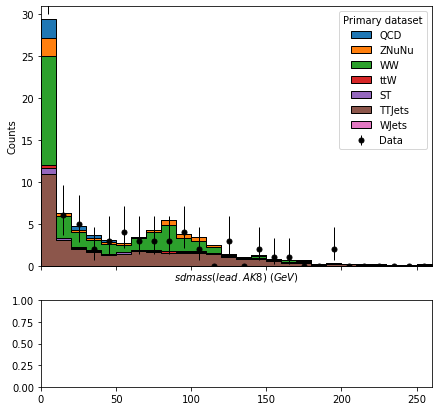

In [45]:
# Make some of the plots

plotDir = '/home/users/ewallace/public_html/sdplots/'
finalizePlotDir(plotDir)

if not histograms:
    print ("Couldn't find histograms in archive. Quitting.")
    exit()

print ("Plots will appear here:", plotDir )


signal = 'mC750_l1'
processes = ['WJets', 'TTJets', 'ST', 'ttW', 'WW', 'ZNuNu', 'QCD', ]
notdata = re.compile('(?!(Data))')
notsignal = re.compile('(?!%s)'%signal)


for name in bins:
    print (name)
    skip = False
    histogram = output[name]
    
    if not name in bins.keys():
        continue

    axis = bins[name]['axis']
    print (name, axis)
    histogram = histogram.rebin(axis, bins[name]['bins'])

    y_max = histogram.sum("dataset").values(overflow='over')[()].max()
    y_over = histogram.sum("dataset").values(overflow='over')[()][-1]

    MC_total = histogram[notdata].sum("dataset").values(overflow='over')[()].sum()
    Data_total = histogram['Data'].sum("dataset").values(overflow='over')[()].sum()

    if normalize:
        scales = {process: Data_total/MC_total for process in processes }
        histogram.scale(scales, axis='dataset')
    else:
        scales = {}


    if useData:
        fig, (ax, rax) = plt.subplots(2, 1, figsize=(7,7), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
    else:
        fig, ax = plt.subplots(1,1,figsize=(7,7))

    # get axes
    if useData:
        hist.plot1d(histogram[notdata], overlay="dataset", ax=ax, stack=True, overflow=bins[name]['overflow'], fill_opts=fill_opts, order=processes)
        #hist.plot1d(histogram[notdata], overlay="dataset", ax=ax, stack=True, overflow=bins[name]['overflow'], fill_opts=fill_opts, error_opts=error_opts, order=processes)
        #hist.plot1d(histogram['QCD'], overlay="dataset", ax=ax, stack=False, overflow=bins[name]['overflow'], clear=False, line_opts=None, fill_opts=fill_opts, error_opts=error_opts, order=processes)
        hist.plot1d(histogram['Data'], overlay="dataset", ax=ax, overflow=bins[name]['overflow'], error_opts=data_err_opts, clear=False)
        #hist.plot1d(histogram[signal], overlay="dataset", ax=ax, overflow=bins[name]['overflow'], line_opts={'linewidth':3}, clear=False)

    '''if useData:
        # build ratio
        hist.plotratio(
            num=histogram['Data'].sum("dataset"),
            denom=histogram[notdata].sum("dataset"),
            ax=rax,
            error_opts=data_err_opts,
            denom_fill_opts=None, # triggers this: https://github.com/CoffeaTeam/coffea/blob/master/coffea/hist/plot.py#L376
            guide_opts={},
            unc='num',
            #unc=None,
            overflow=bins[name]['overflow']
        )'''


    for l in ['linear', 'log']:
        if useData:
            saveFig(fig, ax, rax, plotDir, name, scale=l, shape=False, y_max=y_max, preliminary='Simulation', lumi=lumis[year], normalize = False)
        else:
            saveFig(fig, ax, None, plotDir, name, scale=l, shape=False, y_max=y_max)
    fig.clear()
    if useData:
        rax.clear()
    ax.clear()


To do:
-Plot data with correct weight
-compare with plot for sdmass_nom
-figure out what selections are begin used (why do I have so much less W+jets, QCD?)